In [1]:
# Load packages

# General math packages
import numpy as np
from scipy.integrate import odeint
import math

# Visualization
import matplotlib.pyplot as plt

# Data Science
import tensorflow as tf

## Create model for pendulum behaviour + generate data

In [2]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Function that returns dtheta/dt.
def model(theta, t, bm, l):
    g = 9.81
    theta1 = theta[0]
    theta2 = theta[1]
    dtheta1_dt = theta2
    dtheta2_dt = -(bm) * theta2 - (g / l) * math.sin(theta1)
    dtheta_dt = [dtheta1_dt, dtheta2_dt]
    return dtheta_dt


In [3]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Inputs
b = 0.5
l = 1
m = 1
bm = b/m
actual_params = [b/m, l]
actual_theta_0 = [math.pi/2, 0]
t_min = 0
t_max = 5
t_step = 0.05
t = np.arange(t_min, t_max + t_step, t_step)

# Actual theta values (assuming these are measured data)
actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

In [4]:
# Generate noise
noise_sd = 0
np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

# Adding noise to the data
actual_theta_noisy = np.copy(actual_theta)
actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

In [5]:
# Generate training dataset

# Adjusting the time range
t_max_new = 0.75  # Set the maximum time to 0.75 seconds
t_train = np.arange(t_min, t_max_new + t_step, t_step)

# Finding the index corresponding to the first second
index_train = int(t_max_new / t_step) + 1

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_noisy_train = actual_theta_noisy[:index_train]

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_train = actual_theta[:index_train]

## Phisics Informed Neural Network (known parameters)

In [6]:
# Define a custom sine activation function
def sin_activation(x):
    return tf.sin(x)

# Define the neural network architecture
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(64, activation=sin_activation)
        self.out = tf.keras.layers.Dense(2)  # Output: [theta1, theta2]
    
    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        x = self.dense3(x)
        theta = self.out(x)
        return theta

In [7]:
# Define the loss function
def loss_fn(pinn, t_train_tensor, t_tensor, actual_theta_noisy_train_tensor, bm, l):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        tape1.watch(t_tensor)
        tape2.watch(t_tensor)
        
        theta_pred = pinn(t_tensor)
        theta1_pred = theta_pred[:, 0]
        theta2_pred = theta_pred[:, 1]

        # Compute derivatives
        # Compute the first derivatives for each component
        dtheta1_dt_pred = tape1.gradient(theta1_pred, t_tensor)
        dtheta1_dt_pred = tf.squeeze(dtheta1_dt_pred)

        dtheta2_dt_pred = tape2.gradient(theta2_pred, t_tensor)
        dtheta2_dt_pred = tf.squeeze(dtheta2_dt_pred)

        # Data loss: Mean Squared Error between predicted and noisy data
        theta_pred = pinn(t_train_tensor)
        data_loss = tf.reduce_mean(tf.square(theta_pred[:, 0] - actual_theta_noisy_train_tensor[:, 0]))

        # Physics loss: Based on the differential equations
        g = 9.81
        dtheta1_dt_equation = theta2_pred # 1st equation
        dtheta2_dt_equation = -(bm) * dtheta1_dt_pred - (g / l) * tf.sin(theta1_pred) # 2nd equation
        
        physics_loss_1 = tf.reduce_mean(tf.square(dtheta1_dt_pred - dtheta1_dt_equation))
        physics_loss_2 = tf.reduce_mean(tf.square(dtheta2_dt_pred - dtheta2_dt_equation))

        total_loss = data_loss + 50*physics_loss_1 + 1*physics_loss_2
    return total_loss

In [25]:
# Initialize the neural network
pinn = PINN()

# Convert training data to tensorflow tensors
t_train_tensor = tf.convert_to_tensor(t_train, dtype=tf.float32)
t_train_tensor = tf.reshape(t_train_tensor, (-1, 1))

t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
t_tensor = tf.reshape(t_tensor, (-1, 1))

actual_theta_noisy_train_tensor = tf.convert_to_tensor(actual_theta_noisy_train, dtype=tf.float32)

# Set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Initialize a list to store MSE values
mse_values = []

# Training loop
num_epochs = 20000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(pinn, t_train_tensor, t_tensor, actual_theta_noisy_train_tensor, actual_params[0], actual_params[1])
    grads = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
    
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')
    
    if epoch % 50 == 0:
        mse_values.append(loss.numpy())

# After training, the model should be able to predict theta values that adhere to the differential equations


Epoch 0, Loss: 16.037321090698242
Epoch 200, Loss: 1.020661473274231
Epoch 400, Loss: 1.0196521282196045
Epoch 600, Loss: 1.0215706825256348
Epoch 800, Loss: 1.0170477628707886
Epoch 1000, Loss: 1.015629529953003
Epoch 1200, Loss: 1.0140784978866577
Epoch 1400, Loss: 1.012887954711914
Epoch 1600, Loss: 1.0120022296905518
Epoch 1800, Loss: 1.0115430355072021
Epoch 2000, Loss: 1.011182188987732
Epoch 2200, Loss: 1.0109024047851562
Epoch 2400, Loss: 1.0105102062225342
Epoch 2600, Loss: 1.0101418495178223
Epoch 2800, Loss: 1.009476661682129
Epoch 3000, Loss: 1.008837103843689
Epoch 3200, Loss: 1.0073816776275635
Epoch 3400, Loss: 1.0054280757904053
Epoch 3600, Loss: 0.9997046589851379
Epoch 3800, Loss: 0.9861204028129578
Epoch 4000, Loss: 0.9498581290245056
Epoch 4200, Loss: 0.9207150936126709
Epoch 4400, Loss: 0.902749240398407
Epoch 4600, Loss: 0.8894128799438477
Epoch 4800, Loss: 0.8786328434944153
Epoch 5000, Loss: 0.8693646192550659
Epoch 5200, Loss: 0.8567618727684021
Epoch 5400, Los

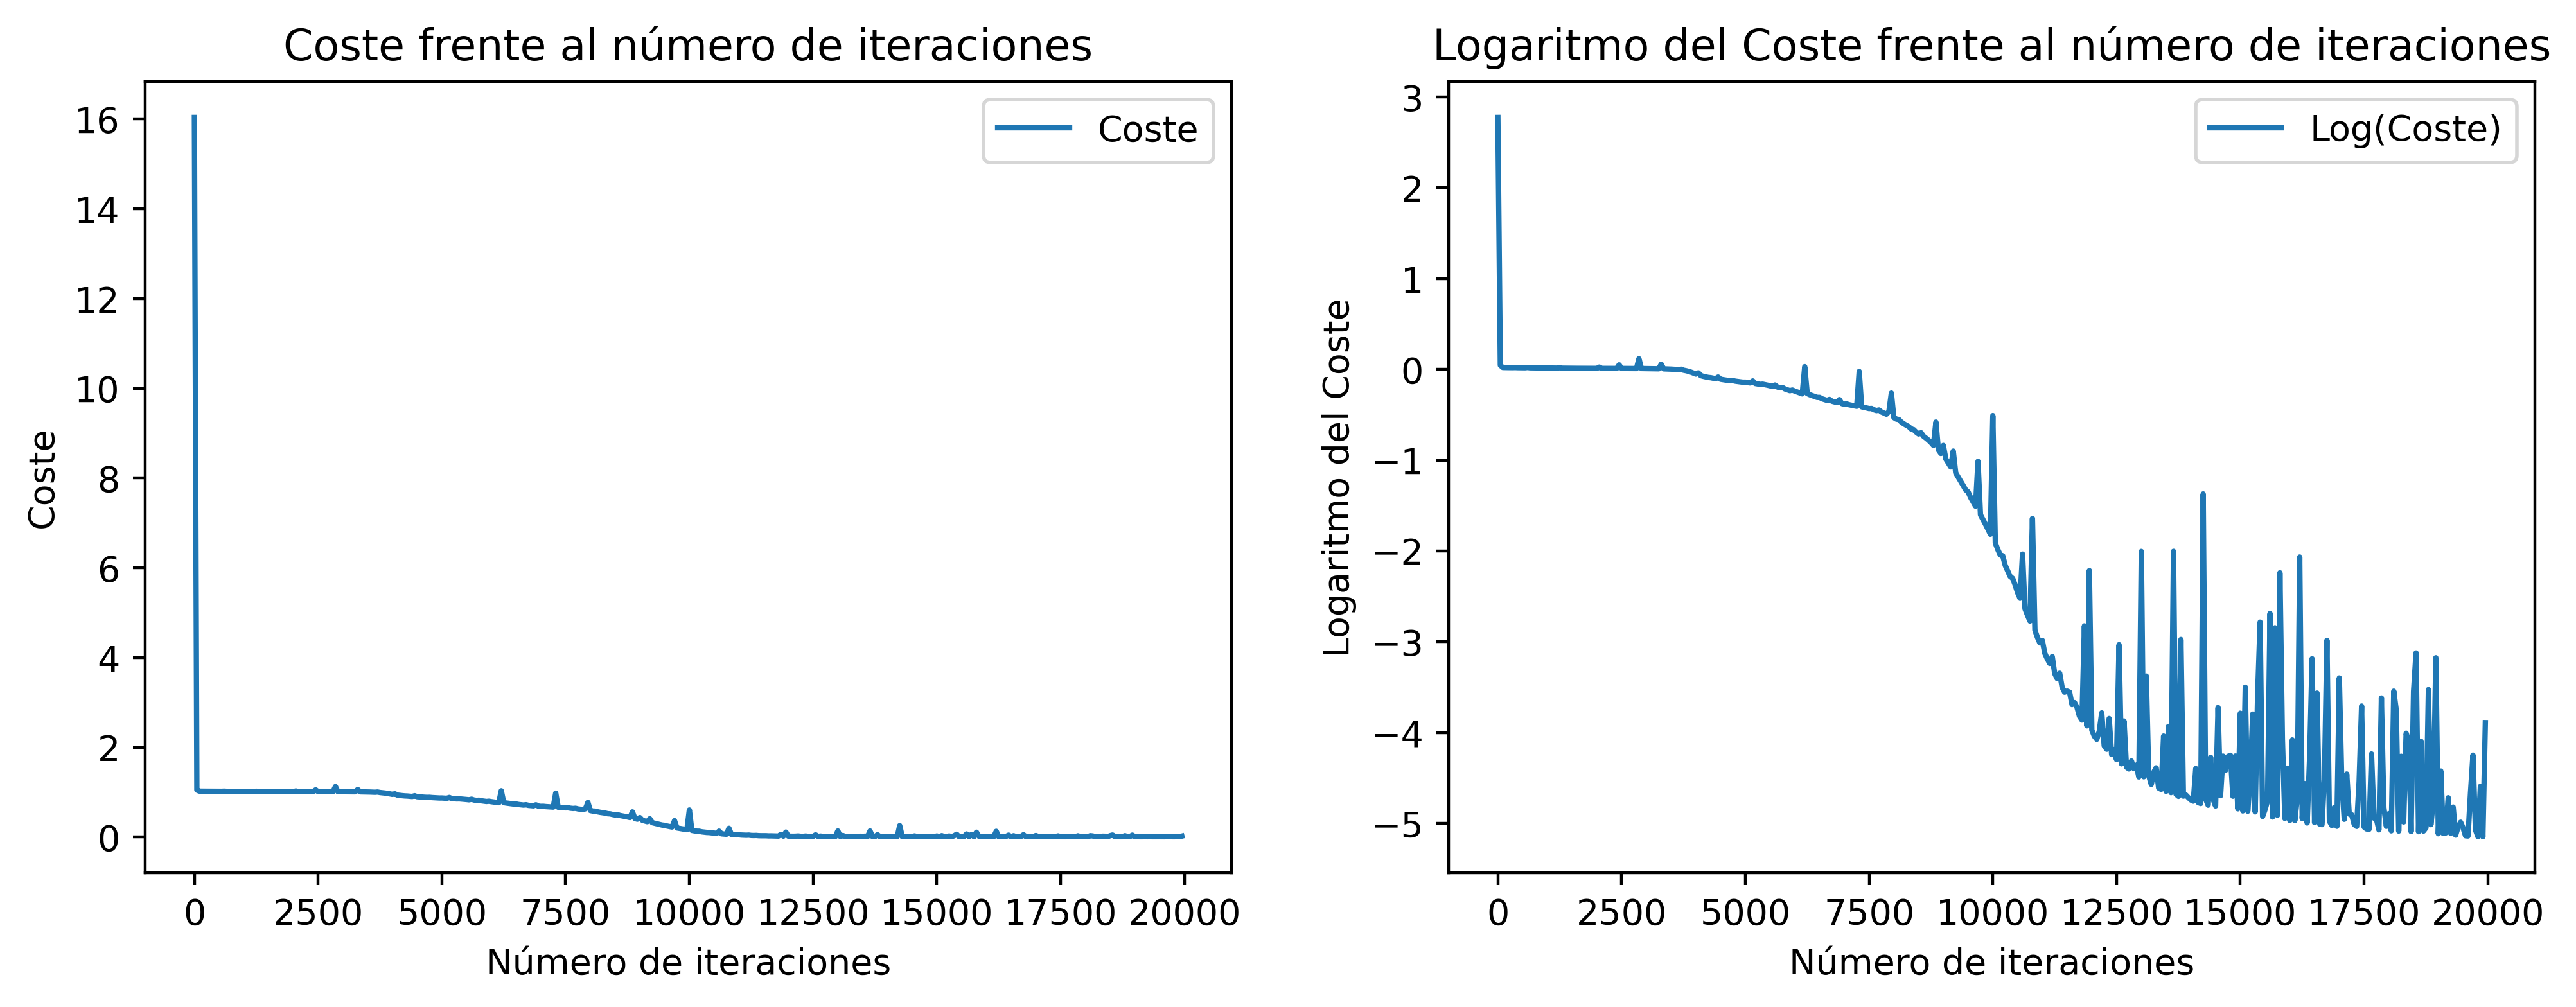

In [26]:
# Plot the results
plt.figure(figsize=(12, 4), dpi=400)

# Plot the MSE values
plt.subplot(1, 2, 1)
plt.plot(range(0, num_epochs, 50), mse_values, label='Coste')
plt.xlabel('Número de iteraciones')
plt.ylabel('Coste')
plt.title('Coste frente al número de iteraciones')
plt.legend()

# Compute the logarithm of the MSE values
log_mse_values = np.log(mse_values)

# Plot the logarithm of MSE values
plt.subplot(1, 2, 2)
plt.plot(range(0, num_epochs, 50), log_mse_values, label='Log(Coste)')
plt.xlabel('Número de iteraciones')
plt.ylabel('Logaritmo del Coste')
plt.title('Logaritmo del coste frente al número de iteraciones')
plt.legend()

plt.show()

## Physics Informed Machine Learning

In [10]:
# Loss function
def loss_function(params, theta_0, t, actual_theta):
    bm, l = params
    predicted_theta = odeint(model, theta_0, t, args=(bm, l,))
    return np.mean((predicted_theta[:,0] - actual_theta[:,0]) ** 2) # + np.mean((predicted_theta[:,1] - np.gradient(predicted_theta[:,0])) ** 2)

# Gradient function
def gradient(params, theta_0, t, actual_theta):
    eps = 1e-5
    grad = np.zeros_like(params)
    for i in range(len(params)):
        params_plus_eps = params.copy()
        params_plus_eps[i] += eps
        params_minus_eps = params.copy()
        params_minus_eps[i] -= eps
        grad[i] = (loss_function(params_plus_eps, theta_0, t, actual_theta) - 
                   loss_function(params_minus_eps, theta_0, t, actual_theta)) / (2 * eps)
    return grad

# Gradient descent function
def gradient_descent(theta_0, t, actual_theta, initial_params, learning_rate=0.01, max_iters=500000, tol=1e-7):
    params = initial_params.copy()
    for i in range(max_iters):
        grad = gradient(params, theta_0, t, actual_theta)
        params -= learning_rate * grad
        if np.linalg.norm(grad) < tol:
            print(f"Converged after {i+1} iterations.")
            break
    return params

In [11]:
# Initial parameters for gradient descent
initial_params = np.array([0.3, 0.8])

# Run gradient descent
estimated_params = gradient_descent(actual_theta_0, t_train, actual_theta_noisy_train, initial_params)
print("Estimated Parameters:", estimated_params)

# Function to simulate the system with estimated parameters
def simulate_system(theta_0, t, estimated_params):
    estimated_theta = odeint(model, theta_0, t, args=tuple(estimated_params))
    return estimated_theta

# Simulate the system with estimated parameters
estimated_theta = simulate_system(actual_theta_0, t, estimated_params)

# Calculate mean squared difference
squared_diff = np.square(actual_theta[:, 0] - estimated_theta[:, 0])
mean_squared_diff = np.mean(squared_diff)
print("Mean Squared Difference:", mean_squared_diff)

Converged after 196942 iterations.
Estimated Parameters: [0.49997819 1.00000482]
Mean Squared Difference: 3.694623742222075e-10


In [12]:
import time

start_ml = time.time()
# Simulate the system with estimated parameters ML
estimated_theta = simulate_system(actual_theta_0, t, estimated_params)
end_ml = time.time()
time_ml = end_ml - start_ml

start_pinn = time.time()
# Simulate the system with estimated parameters PINN
theta_pred = pinn(t_tensor).numpy()
end_pinn = time.time()
time_pinn = end_pinn - start_pinn

print(f'ML time is {time_ml:.4} and PINN time is {time_pinn:.4}')

ML time is 0.000329 and PINN time is 0.002978


## Plot it all together

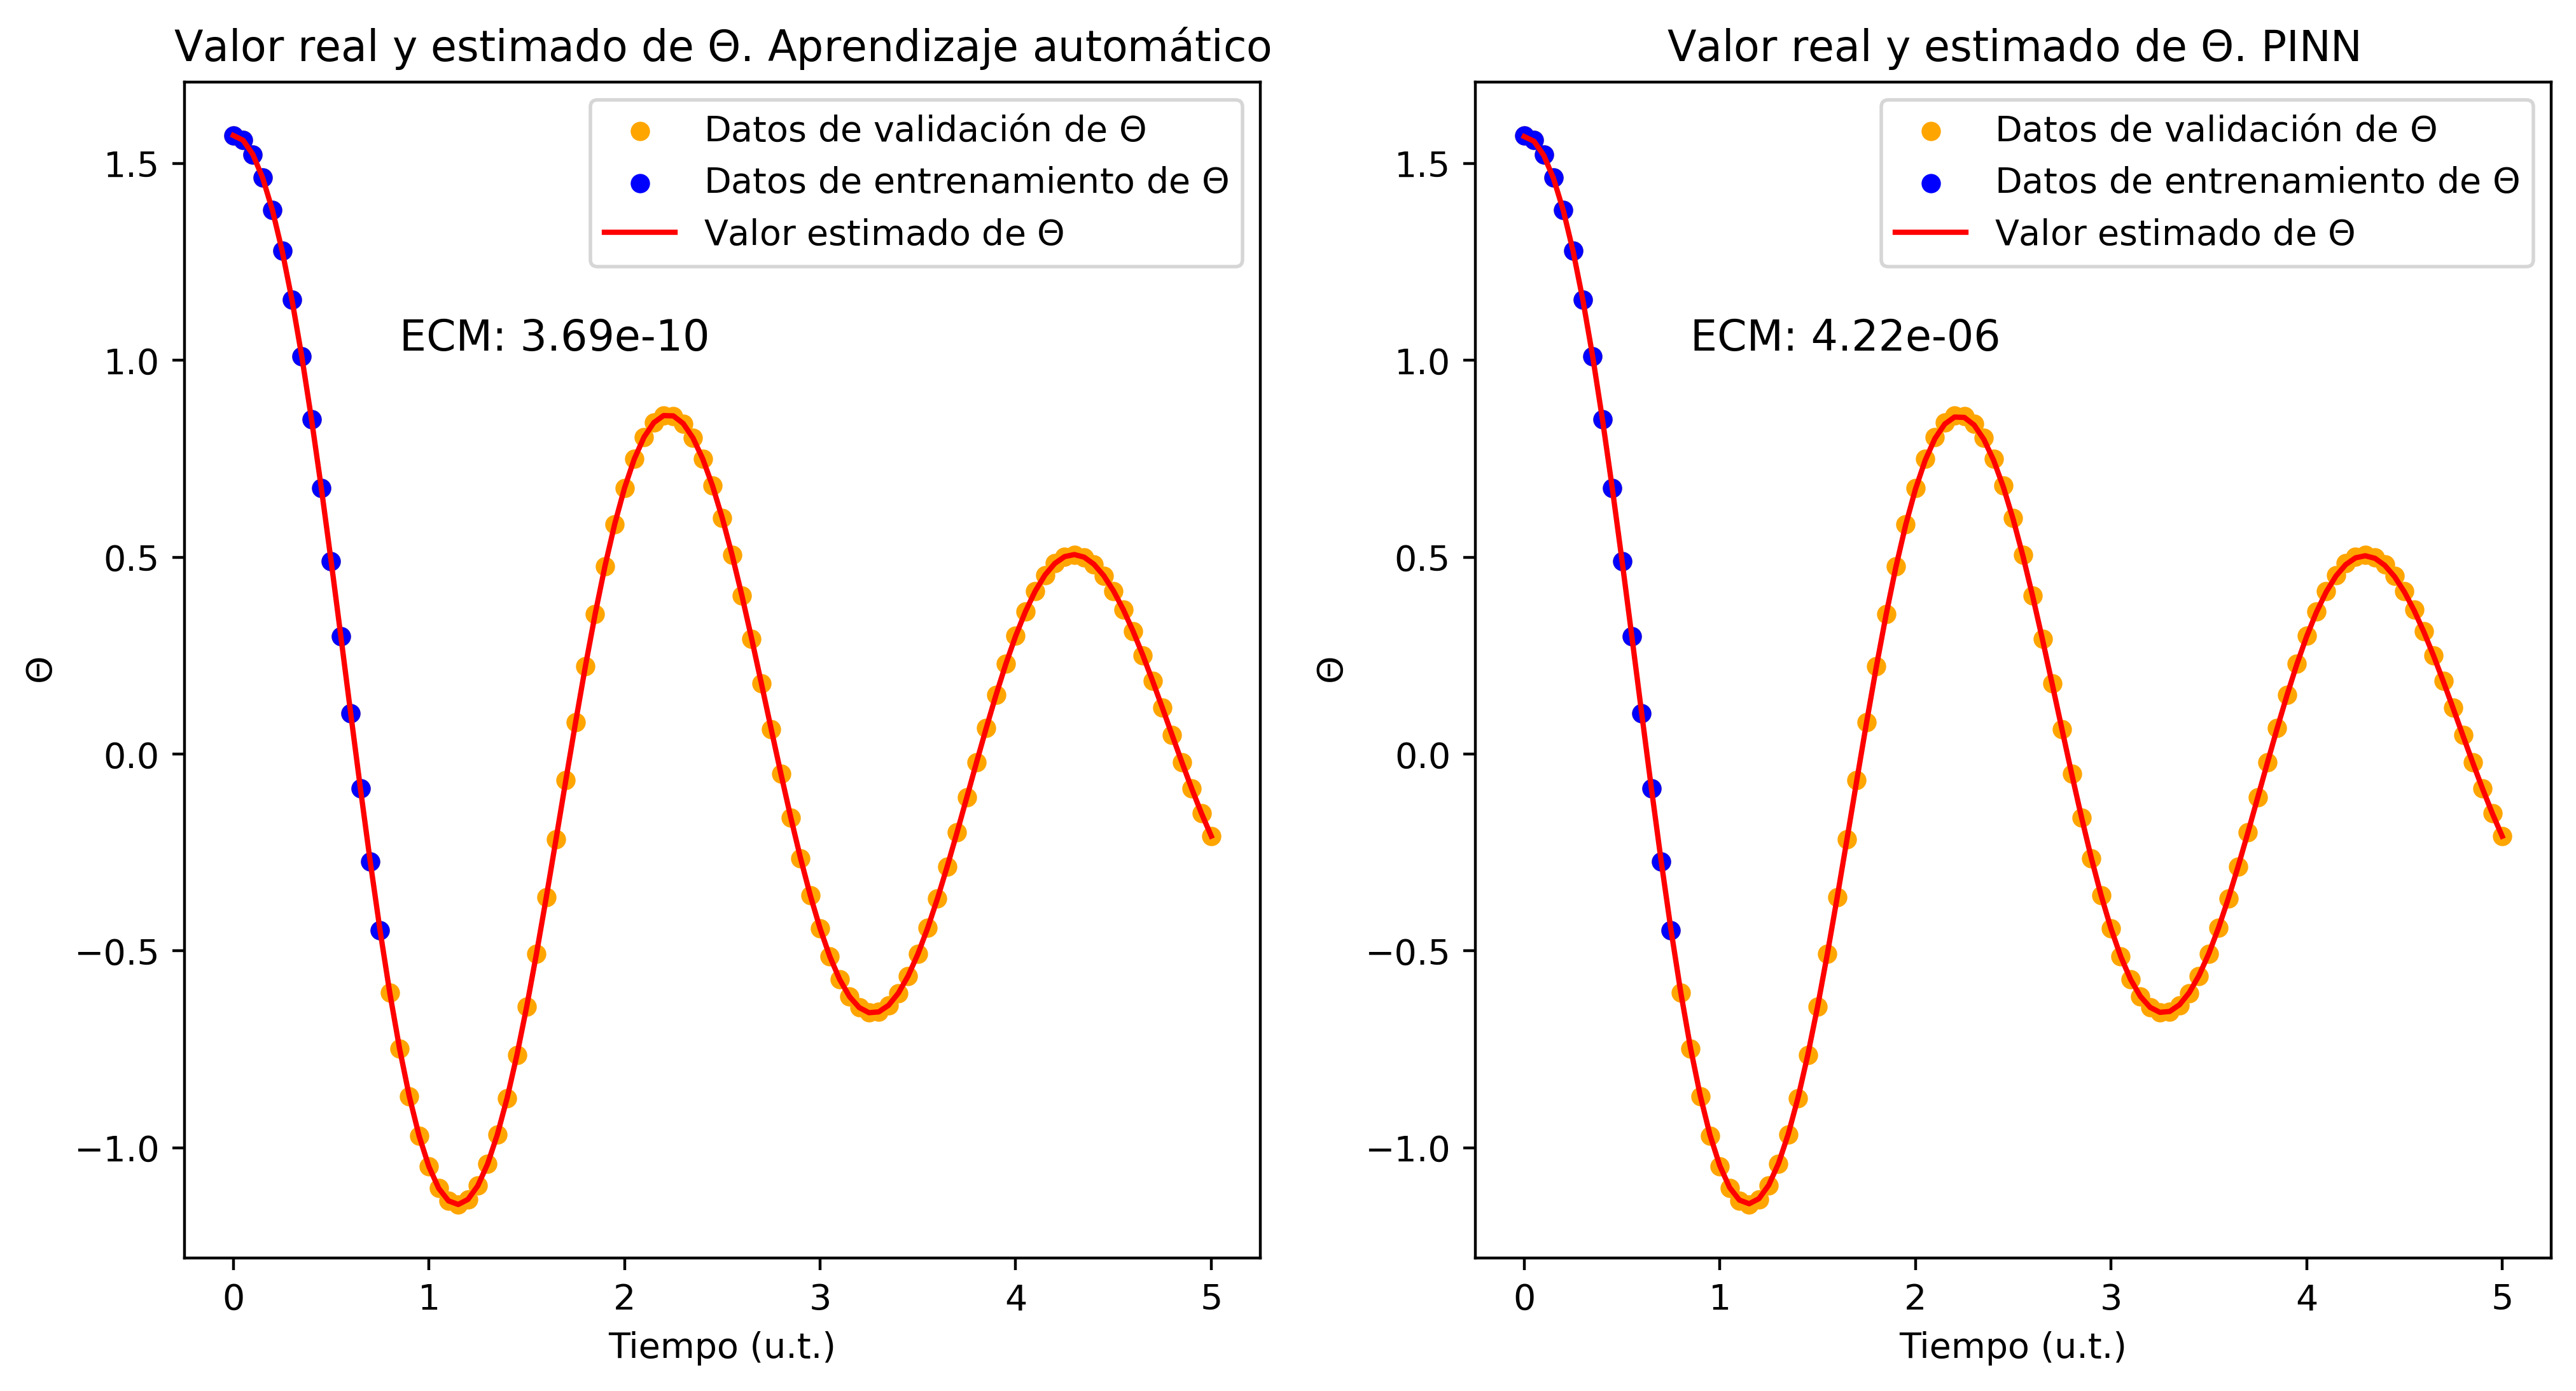

In [20]:
# Predict using the trained model
t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
t_tensor = tf.reshape(t_tensor, (-1, 1))
theta_pred = pinn(t_tensor).numpy()

# Plot the results for ML
plt.figure(figsize=(12, 6), dpi=400)
plt.subplot(1, 2, 1)
plt.scatter(t, actual_theta[:, 0], label=r'Datos de validación de $\Theta$', s=20, color = 'orange')
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
# plt.scatter(t, actual_theta_noisy[:, 0], label='Noisy Theta', s=20)
plt.plot(t, estimated_theta[:, 0], label=r'Valor estimado de $\Theta$', color='red')

# Annotate plot with mean squared difference
plt.text(0.2, 0.8, f'ECM: {mean_squared_diff:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title(r'Valor real y estimado de $\Theta$. Aprendizaje automático')
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.legend()
plt.grid(False)

# Plot the results for the PINN
plt.subplot(1, 2, 2)
plt.scatter(t, actual_theta[:, 0], label=r'Datos de validación de $\Theta$', s=20, color = 'orange')
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t, theta_pred[:, 0], label=r'Valor estimado de $\Theta$', color='red')
mse_known_param = np.mean((actual_theta[:, 0] - theta_pred[:, 0]) ** 2)
plt.text(0.2, 0.8, f'ECM: {mse_known_param:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.grid(False)
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.title(r'Valor real y estimado de $\Theta$. PINN')


plt.show()

## Compare MSE from different methods

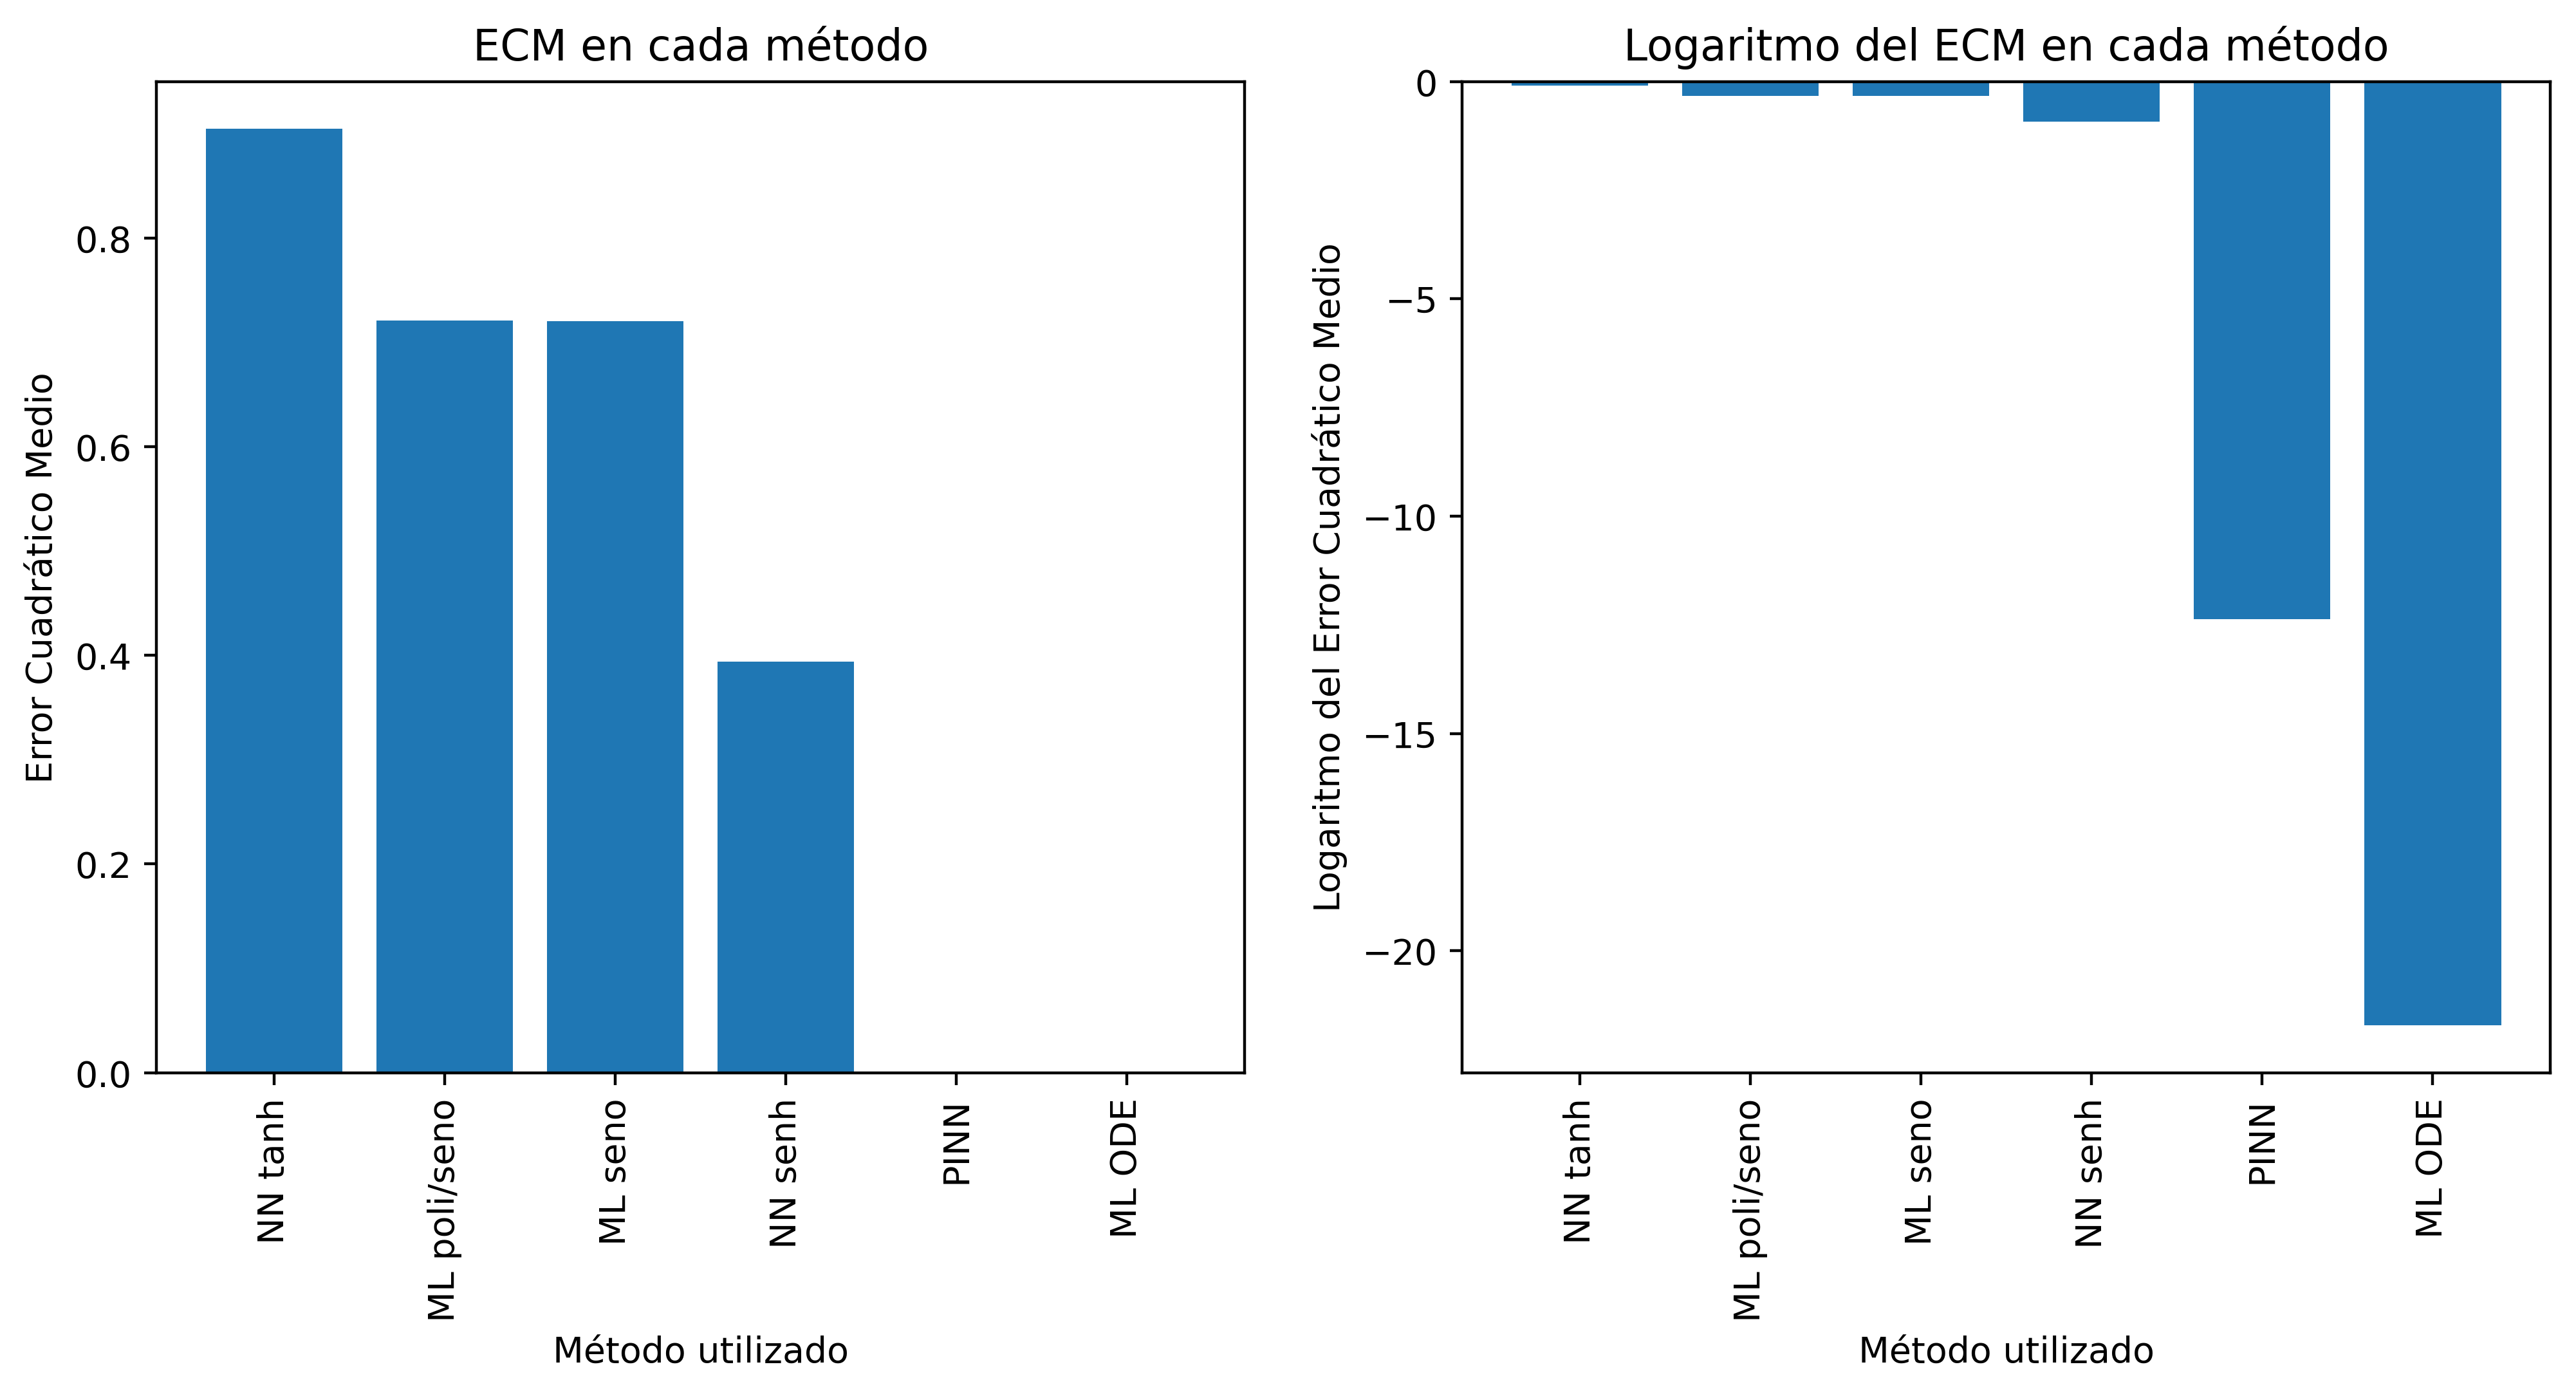

In [21]:
# Data
categories = ['NN tanh', 'ML poli/seno', 'ML seno', 'NN seno', 'PINN', 'ML ODE']
mse_values = [0.905, 0.7210, 0.7206, 0.394, 4.22*10**(-6), 3.7*10**(-10)]

plt.figure(figsize=(12, 5), dpi=400)

plt.subplot(1, 2, 1)

# Create bar chart
plt.bar(categories, mse_values, color='tab:blue')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Método utilizado')
plt.ylabel('Error Cuadrático Medio')
plt.title('ECM en cada método')

plt.subplot(1, 2, 2)

# Compute the logarithm of the MSE values
log_mse_values = np.log(mse_values)

# Create bar chart
plt.bar(categories, log_mse_values, color='tab:blue')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Método utilizado')
plt.ylabel('Logaritmo del Error Cuadrático Medio')
plt.title('Logaritmo del ECM en cada método')

# Display the plot
plt.show()